In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Merge
from keras.models import Sequential, Model
from keras.optimizers import Nadam

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/home/istarzjh/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
images_dir = os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")

images_path = './Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = './Flickr8k_text/Flickr8k.token.txt'
train_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = './Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")[0:-1]
print(len(captions))
x_train = open(train_path, 'r').read().split("\n")[0:-1]
x_test = open(val_path, 'r').read().split("\n")[0:-1]
print(len(x_train))

40460
6000


In [4]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

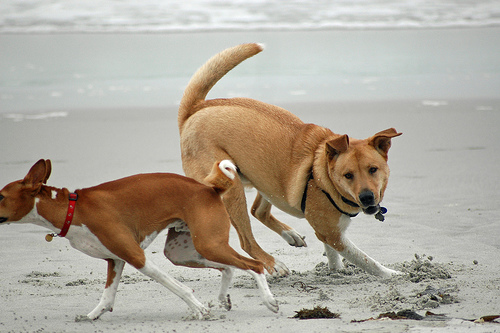

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [5]:
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [6]:
print("Number of Training Images {}".format(len(x_train)))

Number of Training Images 6000


In [7]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [8]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939 
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [9]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [10]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [11]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

# Building Vocabulary #

In [12]:
pd_dataset = pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [13]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))
print(sentences[0])

30000
<start> A black dog is running after a white dog in the snow . <end>


In [14]:
words = [i.split() for i in sentences]

In [15]:
unique = []
for i in words:
    unique.extend(i)

In [16]:
print(len(unique))

413377


In [17]:
unique = list(set(unique))
print(len(unique))

vocab_size = len(unique)

8253


In [18]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [19]:
import json as js

with open('word_2_ind.json') as jfile:
    word_2_indices = js.load(jfile)
jfile.close()

with open('ind_2_word.json') as jfile:
    indices_2_word_ = js.load(jfile)
jfile.close()

indices_2_word = {}

for k,v in indices_2_word_.items():
    indices_2_word[int(k)] = v


print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(indices_2_word[0])

917
tape
dumps


In [20]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


# Model#

In [21]:
captions = np.load("./captions.npy")
next_words = np.load("./next_words.npy")

print(captions.shape)
print(next_words.shape)

(19136, 40)
(19136, 8253)


In [22]:
images = np.load("./images.npy")

print(images.shape)

(19136, 4096)


In [23]:
image_names = np.load("./image_names.npy")
        
print(len(image_names))
print(image_names[1])

19136
2513260012_03d33305cf.jpg


In [24]:
embedding_size = 128

In [25]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(4096,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 524,416
Trainable params: 524,416
Non-trainable params: 0
_________________________________________________________________


In [26]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056384   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,520
Trainable params: 1,483,520
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = Sequential()

model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
model.add(LSTM(1000, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.load_weights("./model_weights.h5")

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), metrics=['accuracy'])
model.summary()

/home/istarzjh/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000)              5028000   
_________________________________________________________________
dense_3 (Dense)              (None, 8253)              8261253   
_________________________________________________________________
activation_1 (Activation)    (None, 8253)              0         
Total params: 15,297,189
Trainable params: 15,297,189
Non-trainable params: 0
_________________________________________________________________


In [40]:
# def scheduler(epoch):
#     if epoch%2==0 and epoch!=0:
#         lr = K.get_value(model.optimizer.lr)
#         K.set_value(model.optimizer.lr, lr*.9)
#         print("lr changed to {}".format(lr*.9))
#     return K.get_value(model.optimizer.lr)

# lr_decay = LearningRateScheduler(scheduler)

model.fit([images, captions], next_words, batch_size=512, epochs= 2)

Epoch 1/2
19136/19136 [==============================] - 8s 442us/step - loss: 0.9722 - acc: 0.6567
Epoch 2/2
19136/19136 [==============================] - 8s 398us/step - loss: 0.9314 - acc: 0.6669


In [41]:
model.save_weights("./model_weights.h5")

# Prediction on test images #

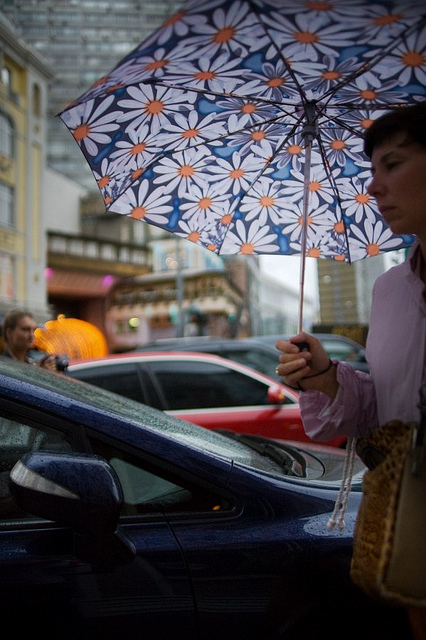

In [42]:
img = "COCO_test2014_000000128266.jpg"

test = ['COCO_test2014_000000107206.jpg', 'COCO_test2014_000000179090.jpg', 'COCO_test2014_000000128266.jpg']

test_img = get_encoding(vgg, img)

z = Image(filename=images_path+img)
display(z)

In [43]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

In [44]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_2_indices["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = model.predict([np.array([image]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:] #Top n prediction
            
            for w in word_preds: #new list so as to feed it to model again
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:] # Top n words
    
    start_word = start_word[-1][0]
    intermediate_caption = [indices_2_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Beam_Search_index_3 = beam_search_predictions(test_img, beam_index=3)
Beam_Search_index_5 = beam_search_predictions(test_img, beam_index=5)
Beam_Search_index_7 = beam_search_predictions(test_img, beam_index=7)

In [45]:
print("Agrmax Prediction : ", Argmax_Search)
print("Beam Search Prediction with Index = 3 : ",Beam_Search_index_3)
print("Beam Search Prediction with Index = 5 : ",Beam_Search_index_5)
print("Beam Search Prediction with Index = 7 : ",Beam_Search_index_7)

Agrmax Prediction :  The kids of Three is in something outside on area on near .
Beam Search Prediction with Index = 3 :  The kids of Three is in something with a blue
Beam Search Prediction with Index = 5 :  The woman is in outside with a top .
Beam Search Prediction with Index = 7 :  The children is in outside with outside .


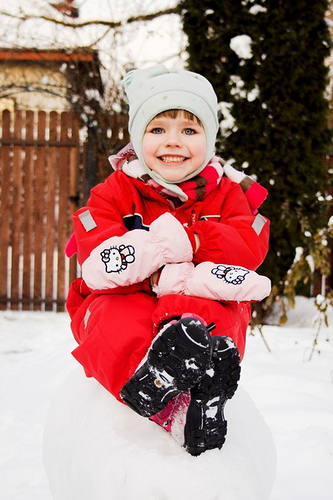

In [69]:
display(z)